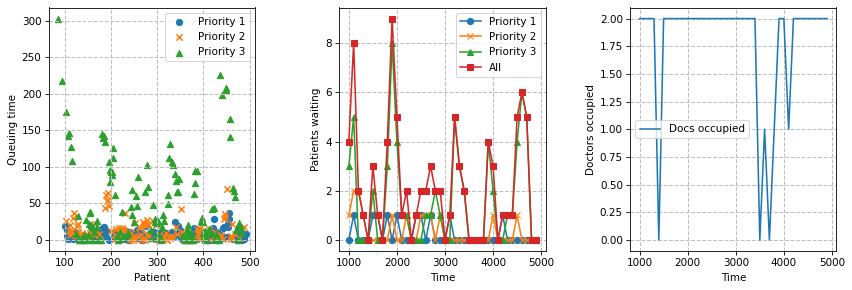

In [1]:
"""This simpy model mimics the arrival and treatment of patients in an
emergency department with a limited number of doctors. Patients are generated,
wait for a doc (if none available), take up the doc resources for the time of
consulation, and exit the ED straight after seeing doc. Patients are of three
priorities (1=high to 3=low) and docs will always see higher priority patients
first (though they do not interrupt lower priority patients already being seen).

The model has four classes:

Global_vars: holds global variables

Model: holds model environemnt and th emain model run methods

Patient: each patient is an object instance of this class. This class also holds
    a static variable (dictionary) containing all patient objects currently in
    the simulation model.

Resources: defines the doc resources required to see/treat patient. 
"""

import simpy
import random
import pandas as pd
import matplotlib.pyplot as plt


class Global_vars:
    """Storage of global variables. No object instance created. All times are
    in minutes"""

    # Simulation run time and warm-up (warm-up is time before audit results are
    # collected)
    sim_duration = 5000
    warm_up = 1000

    # Average time between patients arriving
    inter_arrival_time = 10

    # Number of doctors in ED
    number_of_docs = 2

    # Time between audits
    audit_interval = 100

    # Average and standard deviation of time patients spends being treated in ED
    # (does not include any queuing time, this si the time a doc is occupied
    # with a patient)
    appointment_time_mean = 18
    appointment_time_sd = 7

    # Lists used to store audit results
    audit_time = []
    audit_patients_in_ED = []
    audit_patients_waiting = []
    audit_patients_waiting_p1 = []
    audit_patients_waiting_p2 = []
    audit_patients_waiting_p3 = []
    audit_reources_used = []

    # Set up dataframes to store results (will be transferred from lists)
    patient_queuing_results = pd.DataFrame(
        columns=['priority', 'q_time', 'consult_time'])
    results = pd.DataFrame()

    # Set up counter for number fo aptients entering simulation
    patient_count = 0

    # Set up running counts of patients waiting (total and by priority)
    patients_waiting = 0
    patients_waiting_by_priority = [0, 0, 0]


class Model:
    """
    Model class contains the following methods:

    __init__:  constructor for initiating simpy simulation environment.

    build_audit_results: At end of model run, transfers results held in lists
        into a pandas DataFrame.

    chart: At end of model run, plots model results using MatPlotLib.

    perform_audit: Called at each audit interval. Records simulation time, total
        patients waiting, patients waiting by priority, and number of docs
        occupied. Will then schedule next audit.

    run: Called immediately after initialising simulation object. This method:
        1) Calls method to set up doc resources.
        2) Initialises the two starting processes: patient admissions and audit.
        3) Starts model envrionment.
        4) Save individual patient level results to csv
        5) Calls the build_audit_results metha and saves to csv 
        6) Calls the chart method to plot results

    see_doc: After a patient arrives (generated in the trigger_admissions 
        method of this class), this see_doc process method is called (with
        patient object passed to process method). This process requires a free 
        doc resource (resource objects held in this model class). The request is
        prioritised by patient priority (lower priority numbers grab resources
        first). The number of patients waiting is incremented, and doc resources
        are requested. Once doc resources become available queuing times are
        recorded (these are saved to global results if warm up period has been
        completed). The patient is held for teh required time with doc (held in
        patient object) and then time with doc recorded. The patient is then 
        removed from the Patient calss dictionary (which triggers Python to
        remove the patient object).

    trigger_admissions: Generates new patient admissions. Each patient is an 
        instance of the Patient obect class. This method allocates each
        patient an ID, adds the patient to the dictionary of patients held by
        the Patient class (static class variable), initiates a simpy process
        (in this model class) to see a doc, and schedules the next admission.

    """

    def __init__(self):
        """constructor for initiating simpy simulation environment"""

        self.env = simpy.Environment()

    def build_audit_results(self):
        """At end of model run, transfers results held in lists into a pandas
        DataFrame."""

        Global_vars.results['time'] = Global_vars.audit_time
        Global_vars.results['patients in ED'] = Global_vars.audit_patients_in_ED
        Global_vars.results['all patients waiting'] = \
            Global_vars.audit_patients_waiting
        Global_vars.results['priority 1 patients waiting'] = \
            Global_vars.audit_patients_waiting_p1
        Global_vars.results['priority 2 patients waiting'] = \
            Global_vars.audit_patients_waiting_p2
        Global_vars.results['priority 3 patients waiting'] = \
            Global_vars.audit_patients_waiting_p3
        Global_vars.results['resources occupied'] = \
            Global_vars.audit_reources_used

    def chart(self):
        """At end of model run, plots model results using MatPlotLib."""

        # Define figure size and defintion
        fig = plt.figure(figsize=(12, 4.5), dpi=75)
        # Create two charts side by side

        # Figure 1: patient perspective results
        ax1 = fig.add_subplot(131)  # 1 row, 3 cols, chart position 1
        x = Global_vars.patient_queuing_results.index
        # Chart loops through 3 priorites
        markers = ['o', 'x', '^']
        for priority in range(1, 4):
            x = (Global_vars.patient_queuing_results
                 [Global_vars.patient_queuing_results['priority'] ==
                  priority].index)

            y = (Global_vars.patient_queuing_results
                 [Global_vars.patient_queuing_results['priority'] ==
                  priority]['q_time'])

            ax1.scatter(x, y,
                        marker=markers[priority - 1],
                        label='Priority ' + str(priority))

        ax1.set_xlabel('Patient')
        ax1.set_ylabel('Queuing time')
        ax1.legend()
        ax1.grid(True, which='both', lw=1, ls='--', c='.75')

        # Figure 2: ED level queuing results
        ax2 = fig.add_subplot(132)  # 1 row, 3 cols, chart position 2
        x = Global_vars.results['time']
        y1 = Global_vars.results['priority 1 patients waiting']
        y2 = Global_vars.results['priority 2 patients waiting']
        y3 = Global_vars.results['priority 3 patients waiting']
        y4 = Global_vars.results['all patients waiting']
        ax2.plot(x, y1, marker='o', label='Priority 1')
        ax2.plot(x, y2, marker='x', label='Priority 2')
        ax2.plot(x, y3, marker='^', label='Priority 3')
        ax2.plot(x, y4, marker='s', label='All')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Patients waiting')
        ax2.legend()
        ax2.grid(True, which='both', lw=1, ls='--', c='.75')

        # Figure 3: ED staff usage
        ax3 = fig.add_subplot(133)  # 1 row, 3 cols, chart position 3
        x = Global_vars.results['time']
        y = Global_vars.results['resources occupied']
        ax3.plot(x, y, label='Docs occupied')
        ax3.set_xlabel('Time')
        ax3.set_ylabel('Doctors occupied')
        ax3.legend()
        ax3.grid(True, which='both', lw=1, ls='--', c='.75')

        # Create plot
        plt.tight_layout(pad=3)
        plt.show()

    def perform_audit(self):
        """Called at each audit interval. Records simulation time, total
        patients waiting, patients waiting by priority, and number of docs
        occupied. Will then schedule next audit."""

        # Delay before first aurdit if length of warm-up
        yield self.env.timeout(Global_vars.warm_up)
        # The trigger repeated audits
        while True:
            # Record time
            Global_vars.audit_time.append(self.env.now)
            # Record patients waiting by referencing global variables
            Global_vars.audit_patients_waiting.append(
                Global_vars.patients_waiting)
            Global_vars.audit_patients_waiting_p1.append(
                Global_vars.patients_waiting_by_priority[0])
            Global_vars.audit_patients_waiting_p2.append(
                Global_vars.patients_waiting_by_priority[1])
            Global_vars.audit_patients_waiting_p3.append(
                Global_vars.patients_waiting_by_priority[2])
            # Record patients waiting by asking length of dictionary of all
            # patients (another way of doing things)
            Global_vars.audit_patients_in_ED.append(len(Patient.all_patients))
            # Record resources occupied
            Global_vars.audit_reources_used.append(
                self.doc_resources.docs.count)
            # Trigger next audit after interval
            yield self.env.timeout(Global_vars.audit_interval)

    def run(self):
        """Called immediately after initialising simulation object. This method:
        1) Calls method to set up doc resources.
        2) Initialises the two starting processes: patient admissions and audit.
        3) Starts model envrionment.
        4) Save individual patient level results to csv
        5) Calls the build_audit_results metha and saves to csv 
        6) Calls the chart method to plot results
        """

        # Set up resources using Resouces class
        self.doc_resources = Resources(self.env, Global_vars.number_of_docs)

        # Initialise processes that will run on model run
        self.env.process(self.trigger_admissions())
        self.env.process(self.perform_audit())

        # Run
        self.env.run(until=Global_vars.sim_duration)

        # End of simulation run. Build and save results
        Global_vars.patient_queuing_results.to_csv('patient results.csv')
        self.build_audit_results()

        Global_vars.results.to_csv('operational results.csv')
        # plot results
        self.chart()

    def see_doc(self, p):
        """After a patient arrives (generated in the trigger_admissions 
        method of this class), this see_doc process method is called (with
        patient object passed to process method). This process requires a free 
        doc resource (resource objects held in this model class). The request is
        prioritised by patient priority (lower priority numbers grab resources
        first). The number of patients waiting is incremented, and doc resources
        are requested. Once doc resources become available queuing times are
        recorded (these are saved to global results if warm up period has been
        completed). The patient is held for teh required time with doc (held in
        patient object) and then time with doc recorded. The patient is then 
        removed from the Patient calss dictionary (which triggers Python to
        remove the patient object).
        """

        # See doctor requires doc_resources
        with self.doc_resources.docs.request(priority=p.priority) as req:
            # Increment count of number of patients waiting. 1 is subtracted
            # from priority to align priority (1-3) with zero indexed list.
            Global_vars.patients_waiting += 1
            Global_vars.patients_waiting_by_priority[p.priority - 1] += 1

            # Wait for resources to become available
            yield req

            # Resources now available. Record time patient starts to see doc
            p.time_see_doc = self.env.now

            # Record patient queuing time in patient object
            p.queuing_time = self.env.now - p.time_in

            # Reduce count of number of patients (waiting)
            Global_vars.patients_waiting_by_priority[p.priority - 1] -= 1
            Global_vars.patients_waiting -= 1

            # Create a temporary results list with patient priority and queuing
            # time
            _results = [p.priority, p.queuing_time]

            # Hold patient (with doc) for consulation time required
            yield self.env.timeout(p.consulation_time)

            # At end of consultation add time spent with doc to temp results
            _results.append(self.env.now - p.time_see_doc)

            # Record results in global results data if warm-up complete
            if self.env.now >= Global_vars.warm_up:
                Global_vars.patient_queuing_results.loc[p.id] = _results

            # Delete patient (removal from patient dictionary removes only
            # reference to patient and Python then automatically cleans up)
            del Patient.all_patients[p.id]

    def trigger_admissions(self):
        """Generates new patient admissions. Each patient is an instance of the
        Patient obect class. This method allocates each patient an ID, adds the
        patient to the dictionary of patients held by the Patient class (static
        class variable), initiates a simpy process (in this model class) to see
        a doc, and then schedules the next admission"""

        # While loop continues generating new patients throughout model run
        while True:
            # Initialise new patient (pass environment to be used to record
            # current simulation time)
            p = Patient(self.env)
            # Add patient to dictionary of patients
            Patient.all_patients[p.id] = p
            # Pass patient to see_doc method
            self.env.process(self.see_doc(p))
            # Sample time for next asmissions
            next_admission = random.expovariate(
                1 / Global_vars.inter_arrival_time)
            # Schedule next admission
            yield self.env.timeout(next_admission)


class Patient:
    """The Patient class is for patient objects. Each patient is an instance of
    this class. This class also holds a static dictionary which holds all
    patient objects (a patient is removed after exiting ED).

    Methods are:

    __init__: constructor for new patient
    """

    # The following static class dictionary stores all patient objects
    # This is not actually used further but shows how patients may be tracked
    all_patients = {}

    def __init__(self, env):
        """Constructor for new patient object.
        """

        # Increment global counts of patients
        Global_vars.patient_count += 1

        # Set patient id and priority (random between 1 and 3)
        self.id = Global_vars.patient_count
        self.priority = random.randint(1, 3)

        # Set consultation time (time spent with doc) by random normal
        # distribution. If value <0 then set to 0
        self.consulation_time = random.normalvariate(
            Global_vars.appointment_time_mean, Global_vars.appointment_time_sd)
        self.consulation_time = 0 if self.consulation_time < 0 \
            else self.consulation_time

        # Set initial queuing time as zero (this will be adjusted in model if
        # patient has to waiti for doc)
        self.queuing_time = 0

        # record simulation time patient enters simulation
        self.time_in = env.now

        # Set up variables to record simulation time that patient see doc and
        # exit simulation
        self.time_see_doc = 0
        self.time_out = 0


class Resources:
    """Resources class for simpy. Only resource used is docs"""
    def __init__(self, env, number_of_docs):
        self.docs = simpy.PriorityResource(env, capacity=number_of_docs)


# Run model 
if __name__ == '__main__':
    # Initialise model environment
    model = Model()
    # Run model
    model.run()